# Определение оттока клиентов телеком-компании

## Описание

### Цель проекта

Обучинь модель классификации для прогнозирования оттока клиентов

### Задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- [contract_new.csv](https://code.s3.yandex.net/datasets/contract_new.csv) — информация о договоре;
- [personal_new.csv](https://code.s3.yandex.net/datasets/personal_new.csv) — персональные данные клиента;
- [internet_new.csv](https://code.s3.yandex.net/datasets/internet_new.csv) — информация об интернет-услугах;
- [phone_new.csv](https://code.s3.yandex.net/datasets/phone_new.csv) — информация об услугах телефонии.


Описание полей данных:

- `BeginDate` - дата начала пользования услугами,
- `EndDate` - дата окончания пользования услугами,
- `Туре` - тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` - электронный платёжный документ,
- `PaymentMethod` - способ оплаты,
- `MonthlyCharges` - ежемесячные траты на услуги,
- `TotalCharges` - всего потрачено денег на услуги
- `Dependents` - наличие иждивенцев
- `SeniorCitizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга(и)
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

Во всех файлах столбец `customerID` содержит код клиента.
 
Информация о договорах актуальна на 1 февраля 2020.

Данные также находятся в тренажёре, в папке `/datasets/`

## Импорт и первичный осмотр данных

In [5]:
# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os.path

# Добавим библиотеки для отрисовки графиков
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# инструменты статистического анализа
from scipy.stats import chi2_contingency
import phik

# добавим необходимые библиотеки для построения моделей
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Обозначим глобальные переменные
RANDOM_STATE = 240423

In [6]:
# Импортируем датасеты методом try/except и установим индексом столбец date
print('Загружаем датасет "contract_new.csv"')
try:
    contract_path_df = os.path.join('datasets/contract_new.csv')
    contract_df = pd.read_csv(contract_path_df)
    print('данные загружены с локального хранилища')
except:
    contract_df = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    print('данные загружены с сервера')

print('Загружаем датасет "personal_new.csv"')
try:
    personal_path_df = os.path.join('datasets/personal_new.csv')
    personal_df = pd.read_csv(personal_path_df)
    print('данные загружены с локального хранилища')
except:
    personal_df = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    print('данные загружены с сервера')

print('Загружаем датасет "internet_new.csv"')
try:
    internet_path_df = os.path.join('datasets/internet_new.csv')
    internet_df = pd.read_csv(internet_path_df)
    print('данные загружены с локального хранилища')
except:
    internet_df = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    print('данные загружены с сервера')

print('Загружаем датасет "phone_new.csv"')
try:
    phone_path_df = os.path.join('datasets/phone_new.csv')
    phone_df = pd.read_csv(phone_path_df)
    print('данные загружены с локального хранилища')
except:
    phone_df = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
    print('данные загружены с сервера')

Загружаем датасет "contract_new.csv"
данные загружены с локального хранилища
Загружаем датасет "personal_new.csv"
данные загружены с локального хранилища
Загружаем датасет "internet_new.csv"
данные загружены с локального хранилища
Загружаем датасет "phone_new.csv"
данные загружены с локального хранилища


In [7]:
df_list = [contract_df, personal_df, internet_df, phone_df]
df_name = ['contract_df', 'personal_df', 'internet_df', 'phone_df']

for i,n in zip(df_list, df_name):
    text = f'  информация по датасету {n}  '
    print(f'{text:~^79}')
    display(i.info())
    display(i.head(5))
    display(i.describe())

~~~~~~~~~~~~~~~~~~~~  информация по датасету contract_df  ~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.8500,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.9500,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.8500,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3000,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7000,353.5


,MonthlyCharges
count,7043.0000
mean,64.7617
std,30.0900
min,18.2500
25%,35.5000
50%,70.3500
75%,89.8500
max,118.7500


~~~~~~~~~~~~~~~~~~~~  информация по датасету personal_df  ~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.0000
mean,0.1621
std,0.3686
min,0.0000
25%,0.0000
50%,0.0000
75%,0.0000
max,1.0000


~~~~~~~~~~~~~~~~~~~~  информация по датасету internet_df  ~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


~~~~~~~~~~~~~~~~~~~~~~  информация по датасету phone_df  ~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [8]:
contract_df['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [9]:
# убедимся что поля customerID в датасетах содержат только уникальные значения
for i, n in zip(df_list, df_name):
    print('дубликатов в поле "customerID" датасета ' + n + ':', i['customerID'].duplicated().sum())

дубликатов в поле "customerID" датасета contract_df: 0
дубликатов в поле "customerID" датасета personal_df: 0
дубликатов в поле "customerID" датасета internet_df: 0
дубликатов в поле "customerID" датасета phone_df: 0


### Выводы о первичном осмотре данных

- Названия столбцов хорошо бы записать в змеином регистре, а не в верблюжем
- В датасете есть информация о 7043 договорах, при этом в датасетах с информацией об услугах интернета и телефонии всего 5517 и 6361 записей, следовательно не все клиенты оформляют обе услуги. 
- Датасеты можно объединить по полю `customerID` для удобства работы с ними и сопоставления данных о пользователях и подключенных ими услугах
- Поля `BeginDate` и `EndDate` содержат в себе даты, но записаны в типе данных `object`. стоит это исправить.
- Поле `EndDate` содержит поля "No", из чего следует что пользователь по прежнему пользуется услугами. Это важный для нас пункт, но его сложно использовать в таком виде. Можно на основе этого столбца создать новый столбец с категорией "ушел/не ушел". В дальнейшей работе это можно будет использовать как целевой признак для обучения модели
- Поле `TotalCharges` содержит числовые данные о потраченных средствах, но так же записано в типе данных `object`, следует так же изменить тип данных
- Нужно создать признак с 1 для пользователей, чей `id` присутствует в датасете с услугами телефонии и 0 для остальных

## Предобработка

In [10]:
df = contract_df.merge(personal_df, on = 'customerID').merge(internet_df, on = 'customerID', how = 'left').merge(phone_df, on = 'customerID', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [11]:
# переведём названия столбцоы в змеиный регистр 
def camel_to_snake(str):
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += '_' + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip('_')

df.columns = [camel_to_snake(i) for i in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [12]:
# в целом функция справилась приемлемо, есть только два столбца в которых результат не удовлетворяет
# там где шло 2 заглавные буквы подряд лишний символ "_" не нужен, поправим это руками
df = df.rename(columns={
    'customer_i_d': 'customer_id', 
    'streaming_t_v': 'streaming_tv'
})

In [13]:
# Избавимся от пропусков
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')
df = df.fillna('No')

In [14]:
# Попытка перевести тип данных выдаёт ошибку, по всей видимости помимо числовых данных у нас есть строки с пробелом в которых нет значений. Проверим
df[df['total_charges'] == ' ']['total_charges'].count()

11

In [15]:
# Да, так и есть, заменим пробелы на нулевые значения и вновь поменяем тип данных
df['total_charges'] = df['total_charges'].replace(" ", 0).astype('float64')

In [16]:
df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.8500,31.0400,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.9500,2071.8400,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.8500,226.1700,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3000,1960.6000,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7000,353.5000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [17]:
col_binar = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

for col in col_binar:
    df[col] = df[col].apply(lambda x: 0 if x == 'No' else 1)

In [18]:
# из колонки с датой окончания договора создадим новую категорию "ушел/не ушел"
df['gone'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [19]:
# Известно что информация актуальна на 1 февраля 2020, поэтому заменим значения 'No' в end_date на это число
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

In [20]:
# посчитаем сколько месяцев абонент пользовался услугами, запишем результат в отдельном столбце, а от столбцов начала и окончания избавимся 
df['user_for_days'] = ((df['end_date'] - df['begin_date']) / np.timedelta64(1, 'D')).astype(int)
df = df.drop(['begin_date','end_date'], axis=1 )

## Анализ данных

процент ушедших: 15.6%


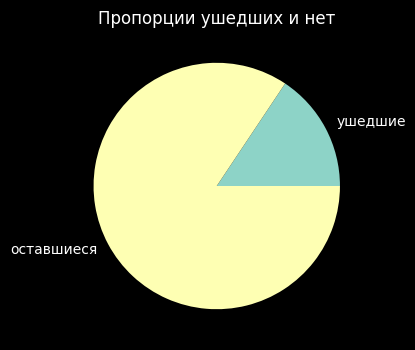

In [21]:
gone_percent = round(df['gone'].mean() * 100, 1)
print(f'процент ушедших: {gone_percent }%')
plt.figure(figsize=(4,4))
plt.pie([df['gone'].mean(),1-df['gone'].mean()], labels=['ушедшие', 'оставшиеся'])
plt.title('Пропорции ушедших и нет')
plt.show();

В данных присутствует дисбаланс классов

### Анализ категориальных признаков

Используем chi2_contingency для определения статистической значимости признаков на целевой признак (ушел клиент)

Нулевая гипотеза: признак не связан с оттоком клиентов

Значение порога `alpha` определим в 0.05.

~~~~~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре type  ~~~~~~~~~~~~~~~~


,type,gone,remain
0,Month-to-month,407,3468
1,One year,313,1160
2,Two year,381,1314


p-value: 3.065849096341664e-38
Отклонить нулевую гипотезу


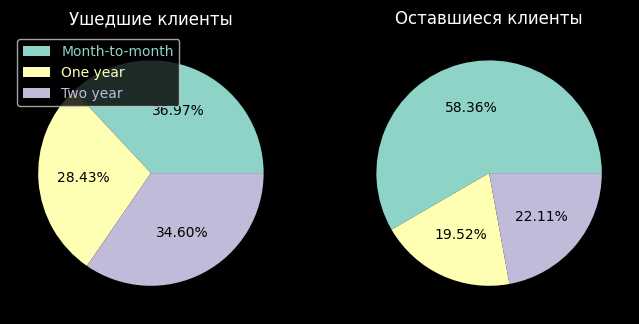

~~~~~~~~~  Проверяем нулевую гипотезу на параметре paperless_billing  ~~~~~~~~~


,paperless_billing,gone,remain
0,0,380,2492
1,1,721,3450


p-value: 4.846228533723826e-06
Отклонить нулевую гипотезу


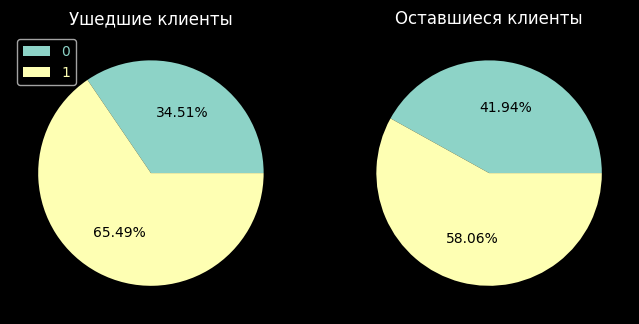

~~~~~~~~~~  Проверяем нулевую гипотезу на параметре payment_method  ~~~~~~~~~~~


,payment_method,gone,remain
0,Bank transfer (automatic),317,1227
1,Credit card (automatic),317,1205
2,Electronic check,350,2015
3,Mailed check,117,1495


p-value: 1.7359650541850085e-31
Отклонить нулевую гипотезу


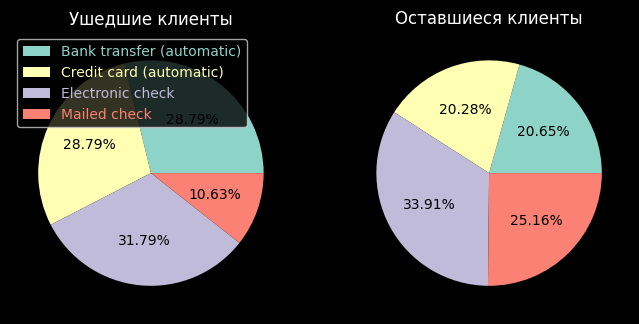

~~~~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре gender  ~~~~~~~~~~~~~~~


,gender,gone,remain
0,Female,528,2960
1,Male,573,2982


p-value: 0.2712988931477521
Не получилось отклонить нулевую гипотезу


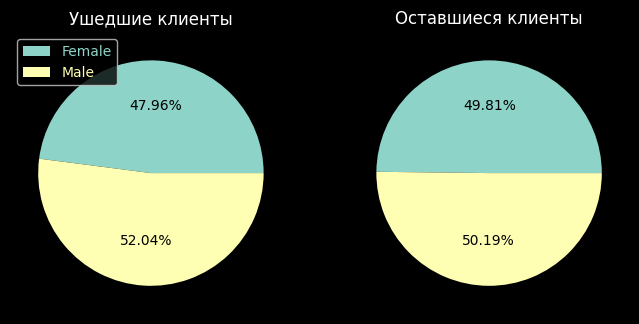

~~~~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре partner  ~~~~~~~~~~~~~~


,partner,gone,remain
0,0,382,3259
1,1,719,2683


p-value: 1.5331159930026101e-34
Отклонить нулевую гипотезу


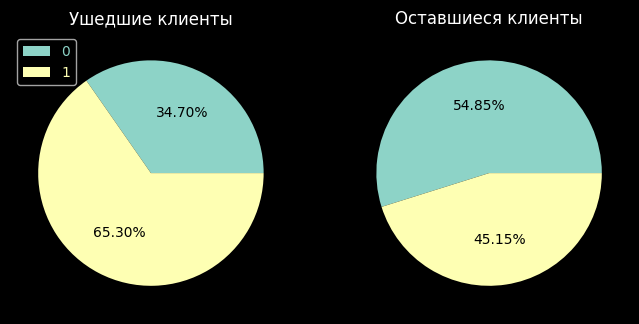

~~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре dependents  ~~~~~~~~~~~~~


,dependents,gone,remain
0,0,733,4200
1,1,368,1742


p-value: 0.006996418239573212
Отклонить нулевую гипотезу


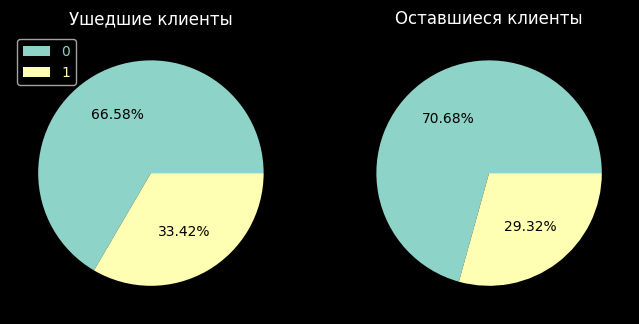

~~~~~~~~~~  Проверяем нулевую гипотезу на параметре senior_citizen  ~~~~~~~~~~~


,senior_citizen,gone,remain
0,0,869,5032
1,1,232,910


p-value: 2.4066754883142295e-06
Отклонить нулевую гипотезу


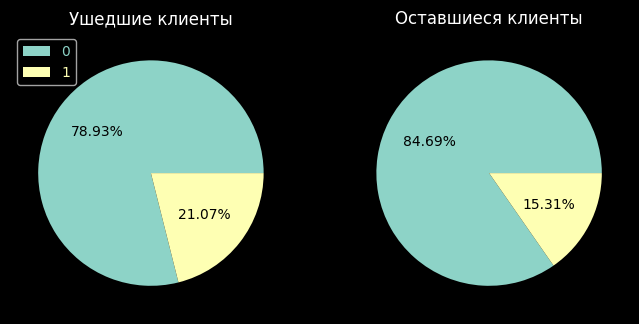

~~~~~~~~~  Проверяем нулевую гипотезу на параметре internet_service  ~~~~~~~~~~


,internet_service,gone,remain
0,DSL,346,2075
1,Fiber optic,595,2501
2,No,160,1366


p-value: 1.1787764842848554e-14
Отклонить нулевую гипотезу


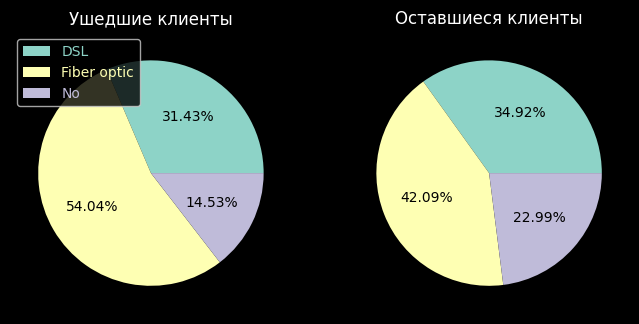

~~~~~~~~~~  Проверяем нулевую гипотезу на параметре online_security  ~~~~~~~~~~


,online_security,gone,remain
0,0,686,4338
1,1,415,1604


p-value: 7.260860275182705e-13
Отклонить нулевую гипотезу


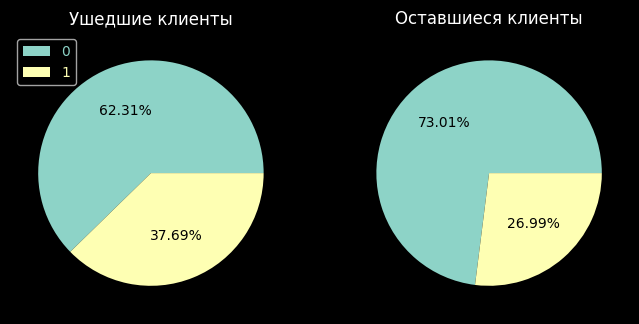

~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре online_backup  ~~~~~~~~~~~


,online_backup,gone,remain
0,0,541,4073
1,1,560,1869


p-value: 2.3008102924477676e-35
Отклонить нулевую гипотезу


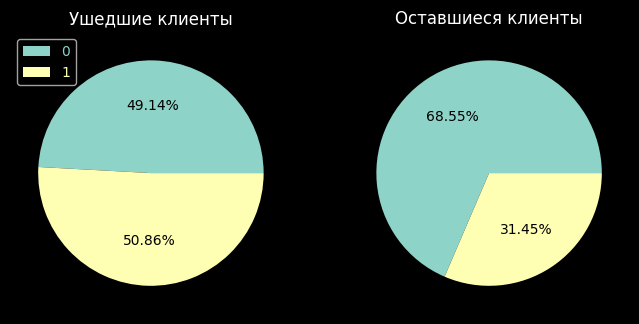

~~~~~~~~~  Проверяем нулевую гипотезу на параметре device_protection  ~~~~~~~~~


,device_protection,gone,remain
0,0,551,4070
1,1,550,1872


p-value: 3.742336045663829e-32
Отклонить нулевую гипотезу


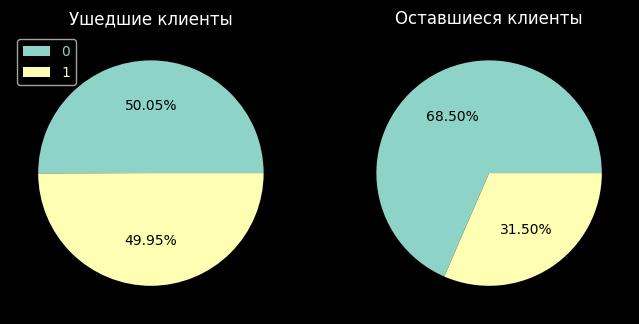

~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре tech_support  ~~~~~~~~~~~~


,tech_support,gone,remain
0,0,703,4296
1,1,398,1646


p-value: 1.7331714072640974e-08
Отклонить нулевую гипотезу


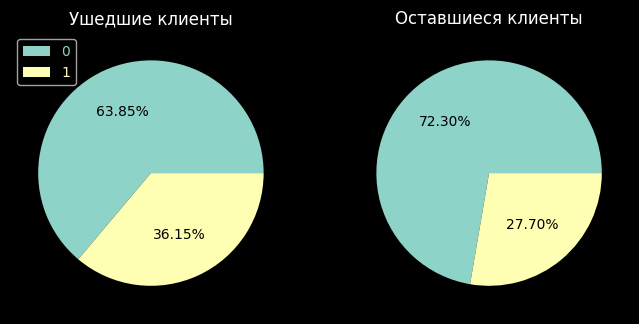

~~~~~~~~~~~  Проверяем нулевую гипотезу на параметре streaming_tv  ~~~~~~~~~~~~


,streaming_tv,gone,remain
0,0,517,3819
1,1,584,2123


p-value: 2.948361091032949e-27
Отклонить нулевую гипотезу


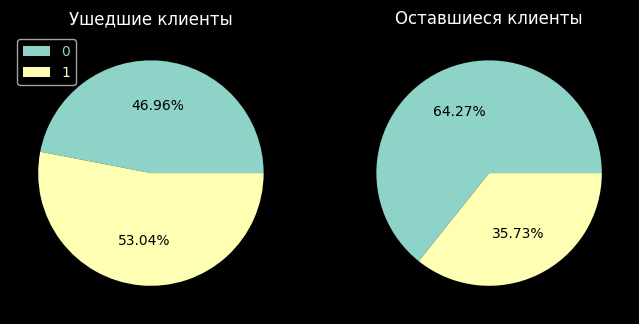

~~~~~~~~~  Проверяем нулевую гипотезу на параметре streaming_movies  ~~~~~~~~~~


,streaming_movies,gone,remain
0,0,495,3816
1,1,606,2126


p-value: 2.9992779995344396e-33
Отклонить нулевую гипотезу


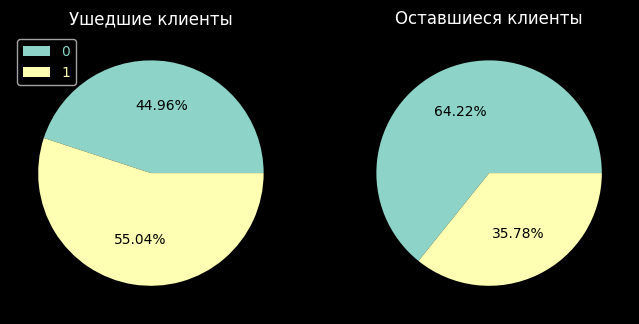

~~~~~~~~~~  Проверяем нулевую гипотезу на параметре multiple_lines  ~~~~~~~~~~~


,multiple_lines,gone,remain
0,0,320,3070
1,1,781,2872


p-value: 4.841986902951681e-43
Отклонить нулевую гипотезу


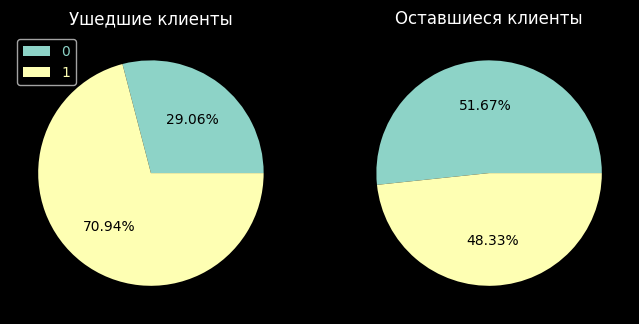

In [22]:
categorical_params = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

alpha = 0.05

def chi2(X):
    sum_table = df.groupby(X, as_index=False)['gone'].sum()
    count_table = df.groupby(X, as_index=False)['customer_id'].count()
    pivot = sum_table.merge(count_table, on=X)
    pivot['remain'] = pivot['customer_id'] - pivot['gone']
    pivot = pivot.drop('customer_id', axis=1)  
    stat, p, dof, expected = chi2_contingency(pivot[['gone', 'remain']])
    return pivot, p

for x in categorical_params:
    pivot, p_value = chi2(x)

    text = f'  Проверяем нулевую гипотезу на параметре {x}  '
    print(f'{text:~^79}')

    display(pivot)
    
    print('p-value:', p_value)
    if p_value < alpha:
        print('Отклонить нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.pie(pivot['gone'], autopct='%1.2f%%', textprops={'color':"k"})
    plt.title('Ушедшие клиенты')
    plt.legend(labels=pivot[x], loc='upper left', labelcolor='linecolor')
    plt.subplot(1, 2, 2)
    plt.pie(pivot['remain'], autopct='%1.2f%%', textprops={'color':"k"})
    plt.title('Оставшиеся клиенты')
    plt.show()

interval columns not set, guessing: ['gone', 'paperless_billing', 'partner', 'dependents', 'senior_citizen', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


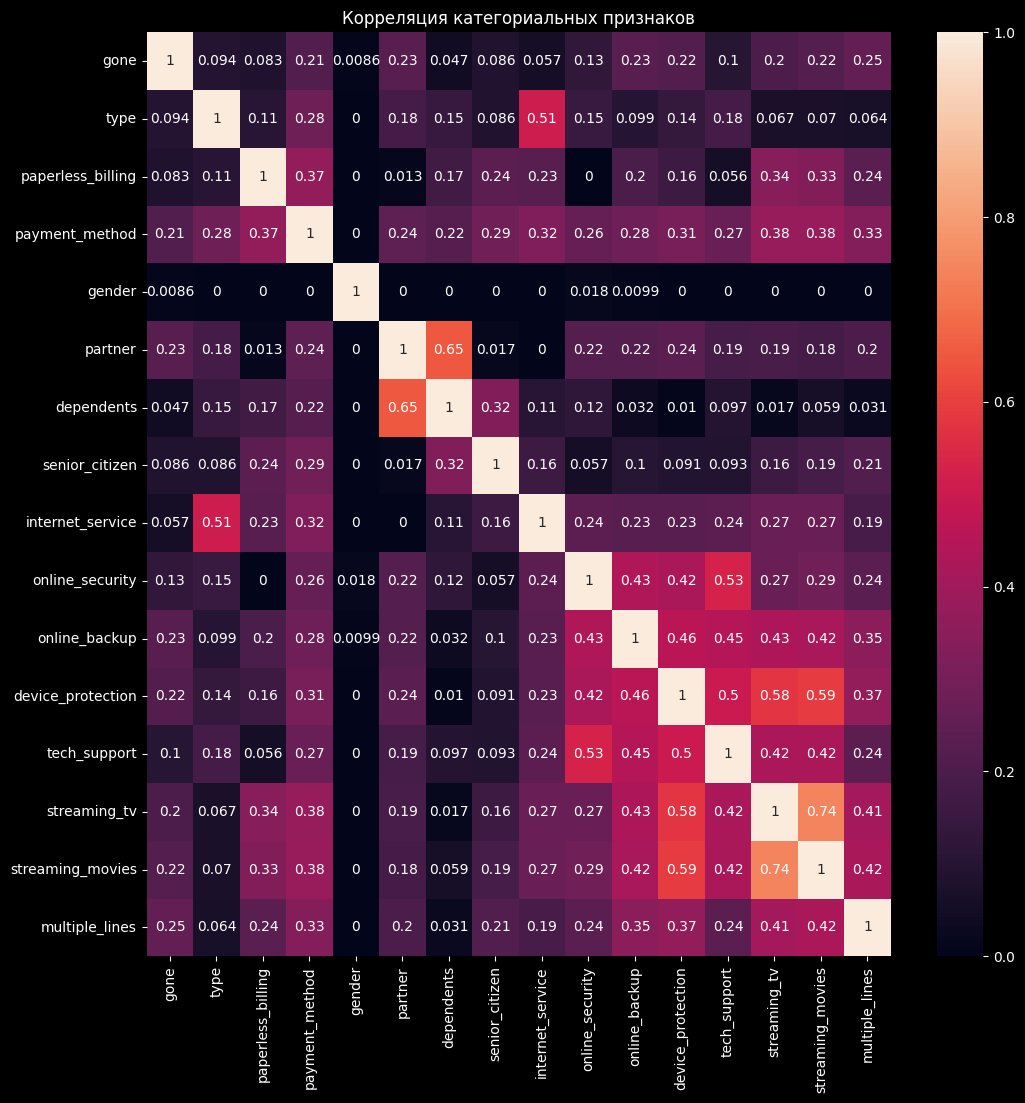

In [23]:
# проверим на мультиколлинеарность
cat_corr_matrix = ['gone', 'type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

plt.figure(figsize=(12, 12))
sns.heatmap(df[cat_corr_matrix].phik_matrix(), annot=True)
plt.title('Корреляция категориальных признаков')
plt.show();

### Вывод по анализу категориальных признаков

- Нулевая гипотеза отклоняется почти во всех случаях кроме пола, следовательно этот признак не является значимум и его можно удалить, остальные влияют на уход клиентов в той или иной мере и будут полезны для обучения модели
- сильно выраженной корреляции с целевым признаком в категориях не замечено
- между собой сильно коррелируют доп услуги подключаемые вместе с интернетом (`device_protection`, `streaming_tv`, `streaming_movies`), что вполне объяснимо.

### Анализ числовых признаков

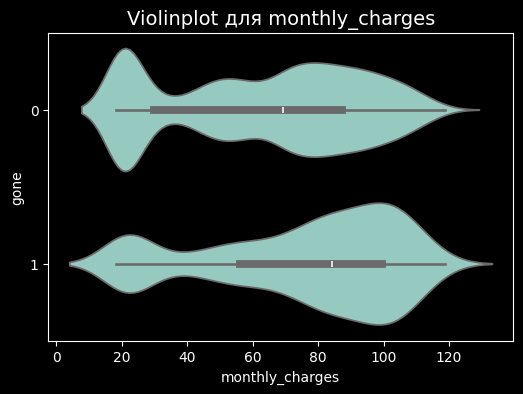

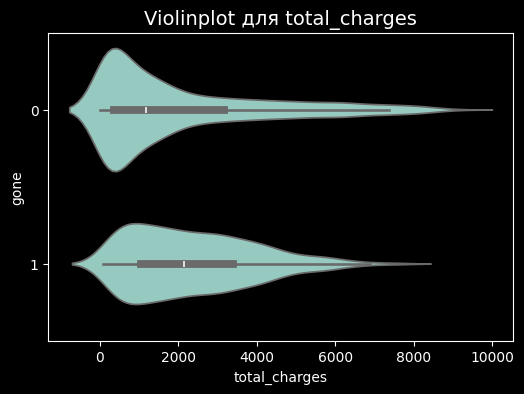

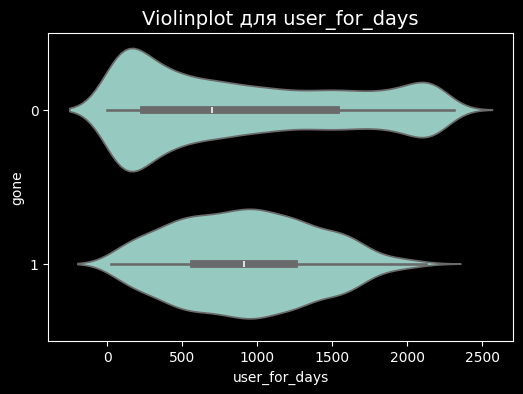

In [24]:
numeric_params = ['monthly_charges', 'total_charges', 'user_for_days']

for x in numeric_params:
    plt.figure(figsize=(6,4))
    plt.title('Violinplot для ' + x, fontsize=14)
    ax = sns.violinplot(y='gone', x=x, orient='h', data=df)
    
    plt.show()

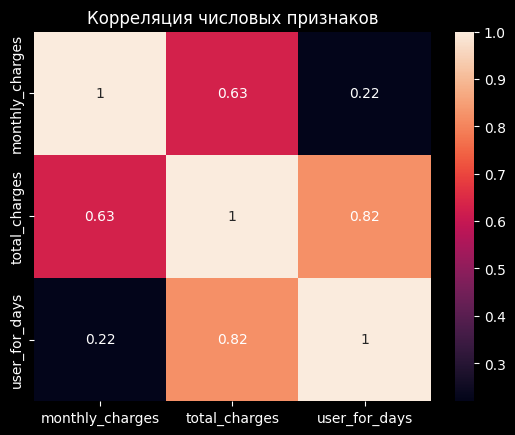

In [25]:
# проверим будут ли общие затраты сильно коррелировать с количеством месяцев, которые аббонент пользовался услугами.
sns.heatmap(df[numeric_params].corr(), annot=True)
plt.title('Корреляция числовых признаков')
plt.show()

<Figure size 800x800 with 0 Axes>

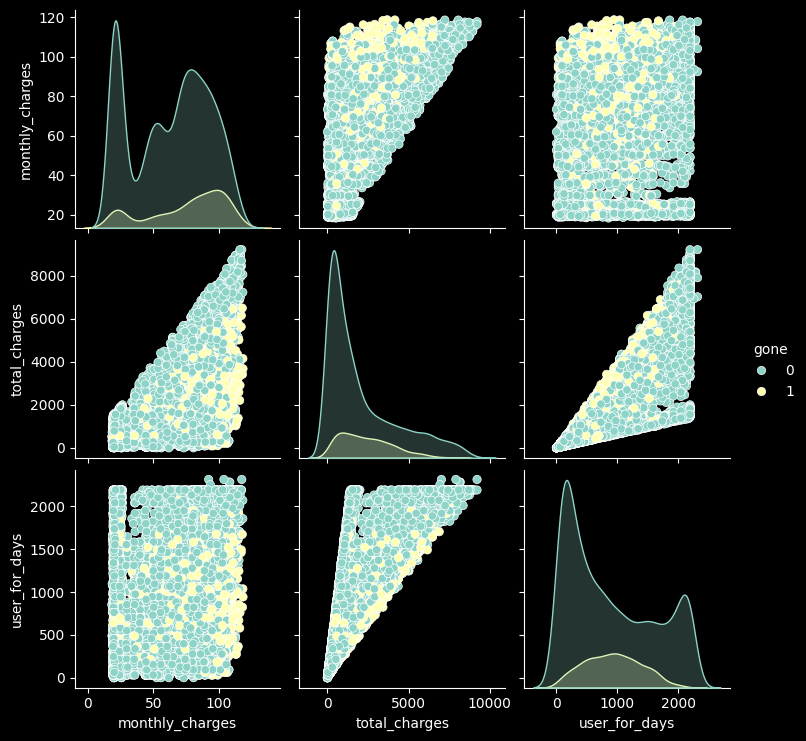

In [26]:
# Также неплохо бы посмотреть диаграммы рассеяния(pairplot) в зависимости от таргета.
numeric_params_and_gone = ['monthly_charges', 'total_charges', 'user_for_days', 'gone']

plt.figure(figsize=(8,8))
sns.pairplot(df[numeric_params_and_gone], hue='gone')
plt.show();

### Вывод по анализу числовых признаков

- ушедшие клиенты платили в месяц больше, чем те которые остаются, в основном около 100, но есть и те, кто платил чуть более 20 и все равно ушел, хотя их меньше и этот горб совпадает с горбом в категории оставшихся и скорее вызван каким-то популярным тарифным планом
- большая доля ушедших, уходит в диапазоне между 600 и 1300 дней
- общая сумма потраченных средств мало информативна. Параметр `total_charges` сильно линейно коррелирует с количеством месяцев пользования услугами (`user_for_days`) и с месячной платой (`monthly_charges`), следовательно от этого параметра можно избавится и модели от этого станет только лучше.

In [27]:
df = df.drop(['customer_id', 'gender', 'total_charges'], axis=1)

### Вывод по анализу данных

- данные загружены и проанализированны
- данные объеденены в один общий датасет
- в датасете заполнены пропуски
- выделен целевой признак (клиенты, которые ушли)
- рассчитан дополнительный признак, количество месяцев пользования
- удалены даты начала и конца пользования
- выдвинуты и проверены гипотезы в значимости категориальных признаков, на основе чего удалён признак пола, как не влияющий на отток клиентов
- проанализировано распределение ушедших клиентов в соотношении с числовыми признаками, выявлена сильная линейная зависимость между признаками, вследствии чего решено было избавится от признака общих затрат пользователя
- так же удалён `ID` ползователя как не нужный на этапе обучения модели
- На данном этапе мы оставили 14 признаков + 1 целевой признак

### Список уточняющих вопросов

- Какие метрики лучше подойдут для итоговой модели? Заказчику важно предсказывать всех клиентов, которые собираются уйти для того чтобы минимизировать отток клиентов (тогда можно предложить метрику `recall`), или же ему важнее минимизировать затраты на раздачу промокодов тем кто и не собирается уходить и ему важна точность (тогда можно предложить метрику `precision`), или же ему важно соблюсти золотую середину между описанными выше метриками (тогда можно предложить метрику `F1`). Советую так-же расчитать метрику `ROC-AUC`. Может быть есть какие-то иные пожелания?
- Может ли гипотетически в категориальных данных появится новый тип данных или можно для кодирования этих данных использовать метод get_dummies?
- Что для заказчика важней, скорость обучения модели или качество метрик?

### Дальнейший план работы
<a id="plan"></a>

- Разбить датасет на признаки и целевой признак
- Разбить данные на тренировочную и тестовую выборки (валидационную выборку можно не делать, так как лучше будет использовать кросс-валидацию `K-Fold`)
- Определится с типом кодирования и применить его для оставшихся категориальных признаков используя `pipline`
- Определить метрику качества, по которой будем оценивать.
- Выбрать различные модели классификации и применить их
- С помощью SearchCV подобрать наилучшие параметры отталкиваясь от выбранной метрики для моделей 
- выбрать модель, показавшую лучшие результаты на кросс валидации
- обучить модель на тестовых данных
- проверить модель на адекватность
- сделать выводы
- написать отчет о проделанной работе

## Обучение моделей на кроссвалидации и определение лучшей

### Разбиваем датасет на тренировочную и тестовую выборки

In [28]:
X = df.drop('gone', axis=1)
y = df['gone']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

print('Размер тренировочной выборки:')
print(f'признаки {X_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {X_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (5282, 16);
целевой признак (5282,)
это 75% от датасета

Размер тестовой выборки:
признаки (1761, 16);
целевой признак (1761,)
это 25% от датасета


### Создаём общие объекты и функции для всех моделей

In [29]:
# Датафрейм для сохранения результатов
results = pd.DataFrame(columns=['Модель', 'лучшая ROC-AUC метрика', 'Accuracy метрика при лучшей ROC-AUC', 'лучшая Accuracy метрика', 'ROC-AUC метрика при лучшей Accuracy'])

# KFold кроссвалидация
cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

# Процессор для раздельной обработки категориальных и количественных столбцов в пайплайне
preprocessor = ColumnTransformer(
    transformers=[
        ('to_scale', StandardScaler(), ['monthly_charges', 'user_for_days']),
        ('to_enc', OneHotEncoder(handle_unknown='ignore', drop='first'), ['type', 'payment_method', 'internet_service']),
        ('other', 'passthrough', ['paperless_billing', 'senior_citizen', 'partner', 'dependents',
                                   'online_security', 'online_backup', 'device_protection', 'tech_support', 
                                   'streaming_tv', 'streaming_movies', 'multiple_lines'])
        ]
    )

# метрики
scoring = ['roc_auc', 'accuracy']

In [30]:
# Функция для вывода метрик на экран и сохранения их в общую таблицу результатов
def sch_scores(prefix, full_model_name, n):
    
    # задаём переменные со значениями метрик
    # задаём имена с префиксом
    globals()[f'{prefix}_best_roc_auc'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_roc_auc'][np.where(eval(prefix+'_sch') \
        .cv_results_['rank_test_roc_auc'] == 1)[0][0]]
    
    globals()[f'{prefix}_best_accuracy'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_accuracy'][np.where(eval(prefix+ \
        '_sch').cv_results_['rank_test_accuracy'] == 1)[0][0]]
    
    globals()[f'{prefix}_accuracy_per_roc_auc'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_accuracy'][np.where(eval(prefix+ \
        '_sch').cv_results_['mean_test_roc_auc'] == eval(prefix+'_best_roc_auc'))[0][0]]
    
    globals()[f'{prefix}_roc_auc_per_accuracy'] = eval(prefix+'_sch') \
        .cv_results_['mean_test_roc_auc'][np.where(eval(prefix+ \
        '_sch').cv_results_['mean_test_accuracy'] == eval(prefix+'_best_accuracy'))[0][0]]
    
    # Выведем метрики на экран 
    print(f'{full_model_name}')
    print('~' *79)
    print('Наилучший показатель ROC-AUC на кросс-валидации: ', round(eval(prefix+'_best_roc_auc'), 4))
    print('показатель accuracy при лучшей ROC-AUC: ', round(eval(prefix+'_accuracy_per_roc_auc'), 4))
    print('при параметрах: ', eval(prefix+'_sch').best_params_)
    print('~' *79)
    print('Наилучший показатель accuracy на кросс-валидации: ', round(eval(prefix+'_best_accuracy'), 4))
    print('показатель ROC-AUC при лучшей accuracy: ', round(eval(prefix+'_roc_auc_per_accuracy'), 4))

    # запишем метрики в общую таблицу с результатами по индексу
    results.loc[n] = [full_model_name, 
                    eval(prefix+'_best_roc_auc'),
                    eval(prefix+'_accuracy_per_roc_auc'),
                    eval(prefix+'_best_accuracy'),
                    eval(prefix+'_roc_auc_per_accuracy')
                    ]

In [31]:
# функция расчета метрик ROC-AUC и построения кривой
def roc_auc_chart(model, X, y, prefix, full_model_name, size=5): 
    # Рассчитываем метрики и назначаем переменные с учётом префикса
    globals()[f'{prefix}_proba'] = model.predict_proba(X)
    globals()[f'{prefix}_proba_one'] = eval(prefix+'_proba')[:, 1]
    globals()[f'{prefix}_roc_auc'] = roc_auc_score(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_fpr'], globals()[f'{prefix}_tpr'], globals()[f'{prefix}_treshold'] = roc_curve(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_auc_score'] = auc(eval(prefix+'_fpr'), eval(prefix+'_tpr'))

    # выводим на экран значение метрики
    print(f'{full_model_name}: ROC-AUC = ', round(eval(prefix+'_roc_auc'), 4))

    # строим график
    plt.figure(figsize=(size, size))
    plt.title(f'{full_model_name}: ROC-кривая')
    prefix_auc_score = eval(prefix+'_auc_score')
    plt.plot(eval(prefix+'_fpr'), eval(prefix + '_tpr'), color='darkorange',
            label=f'ROC кривая (area = {round(prefix_auc_score, 4)})')
    plt.plot([0, 1], [0, 1], color='white', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show();

### LogisticRegressionClassifier

Найдём параметры, c помощью `GridSearchCV`

LogisticRegressionClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.7523
показатель accuracy при лучшей ROC-AUC:  0.8586
при параметрах:  {'model__C': 1.0}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель accuracy на кросс-валидации:  0.8588
показатель ROC-AUC при лучшей accuracy:  0.7523

LogisticRegressionClassifier: ROC-AUC =  0.7585


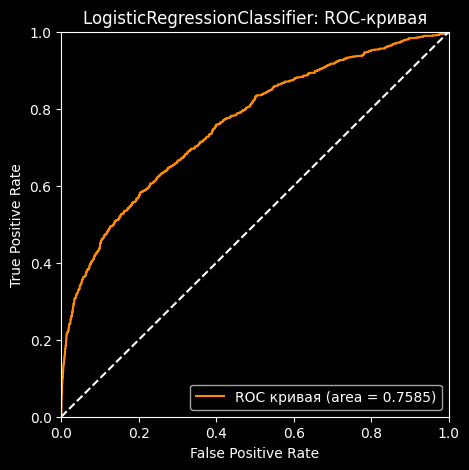

In [32]:
lr_parameters = {'model__C': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 9.0]}

# создаем пайплайн - объединяем преобразованные данные и модель
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', LogisticRegression(random_state=RANDOM_STATE,
                                                       max_iter=1000))])

lr_sch = GridSearchCV(lr_pipe,
                        lr_parameters,
                        cv=cv,
                        scoring=scoring,
                        refit='roc_auc',
                        error_score='raise'
                        )

lr_sch.fit(X_train, y_train)

sch_scores('lr', 'LogisticRegressionClassifier', 0)
print()
roc_auc_chart(lr_sch, X_train, y_train, 'lr', 'LogisticRegressionClassifier')

### RandomForestClassifier

Найдём параметры, c помощью `RandomizedSearchCV`

RandomForestClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.8195
показатель accuracy при лучшей ROC-AUC:  0.8523
при параметрах:  {'model__n_estimators': 800, 'model__min_samples_split': 12, 'model__min_samples_leaf': 3, 'model__max_depth': 8}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель accuracy на кросс-валидации:  0.8567
показатель ROC-AUC при лучшей accuracy:  0.8133

LogisticRegressionClassifier: ROC-AUC =  0.9102


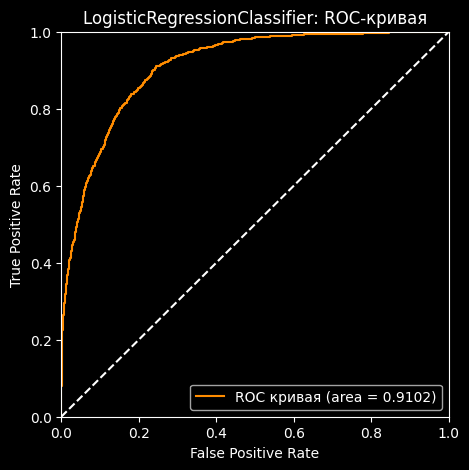

In [33]:
rf_parameters = {'model__n_estimators': range(100, 1001, 50),
                 'model__max_depth': range(1, 21),
                 'model__min_samples_split': range(1, 17),
                 'model__min_samples_leaf': range(1, 17)
                 }

# создаем пайплайн - объединяем преобразованные данные и модель
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestClassifier(random_state=RANDOM_STATE))
                          ])

rf_sch = RandomizedSearchCV(rf_pipe,
                            param_distributions=rf_parameters,
                            n_iter=100,
                            cv=cv,
                            scoring=scoring,
                            refit='roc_auc',
                            random_state=RANDOM_STATE
                            )

rf_sch.fit(X_train, y_train)

sch_scores('rf', 'RandomForestClassifier', 1)
print()
roc_auc_chart(rf_sch, X_train, y_train, 'rf', 'LogisticRegressionClassifier')

### LGBMClassifier

Найдём параметры, c помощью `RandomizedSearchCV`

LGBMClassifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.9073
показатель accuracy при лучшей ROC-AUC:  0.9129
при параметрах:  {'model__verbose': -1, 'model__num_leaves': 37, 'model__n_estimators': 700, 'model__max_depth': 4, 'model__learning_rate': 0.08}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель accuracy на кросс-валидации:  0.9129
показатель ROC-AUC при лучшей accuracy:  0.9073

LGBMClassifier: ROC-AUC =  0.9948


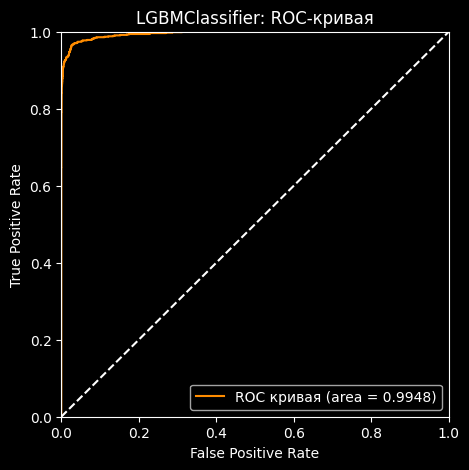

In [34]:
lgbm_parameters = {'model__n_estimators': range(100, 1001, 100),
                   'model__max_depth': [-1, 0, 1, 4, 8, 12, 16],
                   'model__num_leaves': range(20, 51),
                   'model__learning_rate': np.linspace(0.01, 0.2, 20),
                   'model__verbose': [-1]
                   }

# создаем пайплайн - объединяем преобразованные данные и модель
lgbm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LGBMClassifier(random_state=RANDOM_STATE,
                                                     objective='binary'
                                                     )
                          )]
                     )

lgbm_sch = RandomizedSearchCV(lgbm_pipe,
                              param_distributions=lgbm_parameters,
                              n_iter=100,
                              cv=cv,
                              scoring=scoring,
                              refit='roc_auc',
                              random_state=RANDOM_STATE
                              )

lgbm_sch.fit(X_train, y_train)

sch_scores('lgbm', 'LGBMClassifier', 2)
print()
roc_auc_chart(lgbm_sch, X_train, y_train, 'lgbm', 'LGBMClassifier')

### Сравнение моделей

In [35]:
results

,Модель,лучшая ROC-AUC метрика,Accuracy метрика при лучшей ROC-AUC,лучшая Accuracy метрика,ROC-AUC метрика при лучшей Accuracy
0,LogisticRegressionClassifier,0.7523,0.8586,0.8588,0.7523
1,RandomForestClassifier,0.8195,0.8523,0.8567,0.8133
2,LGBMClassifier,0.9073,0.9129,0.9129,0.9073


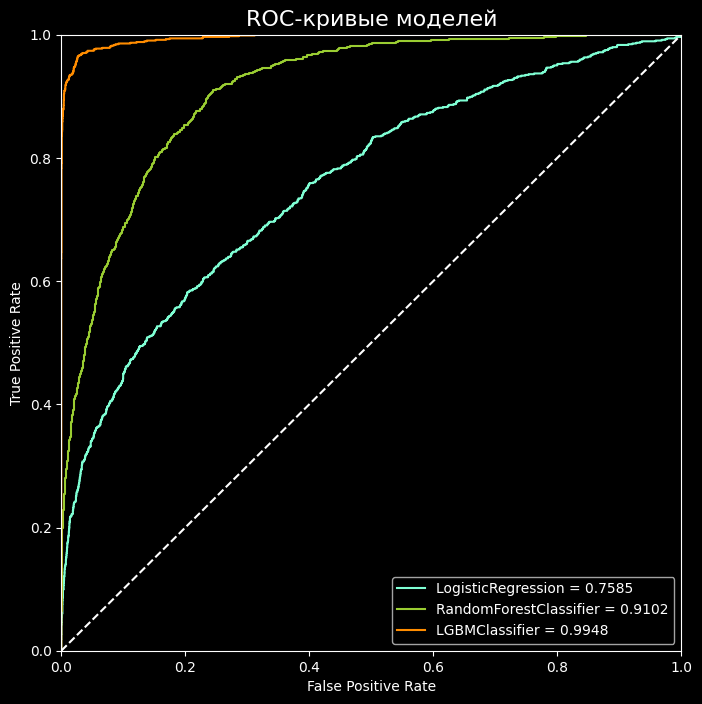

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('ROC-кривые моделей', fontsize=16)
ax.plot(lr_fpr, lr_tpr, color='aquamarine', label=f'LogisticRegression = {round(lr_auc_score, 4)}')
ax.plot(rf_fpr, rf_tpr, color='yellowgreen', label=f'RandomForestClassifier = {round(rf_auc_score, 4)}')
ax.plot(lgbm_fpr, lgbm_tpr, color='darkorange', label=f'LGBMClassifier = {round(lgbm_auc_score, 4)}')

plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show();

На кросс валидации лучшие показатели `ROC-AUC` показывает `LGBMClassifier`, лучшая `Accuracy` так же за ней. 
- лучшие показатели `ROC-AUC` и `Accuracy` в этой модели очень близки друг к другу в том плане что при лучших показателях одной метрики не сильно страдает вторая метрика и наоборот. 
- В других моделях баланс между двумя метриками хуже и если поднимать одну, то вторая просаживаются значительней

Бесспорным фаворитом в нашем сравнении является `LGBMClassifier`
параметры, которые мы подобрали:
 - `num_leaves` = 37, 
 - `n_estimators` = 700, 
 - `max_depth` = 4, 
 - `learning_rate` = 0.08

## Обучим лучшую модель на тестовой выборке

LGBMClassifier: ROC-AUC =  0.9163


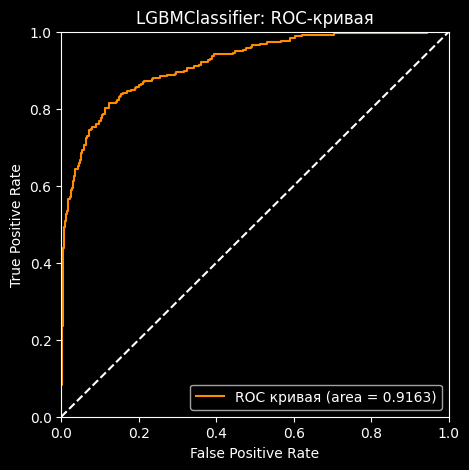

Accuracy лучшей модели на тестовой выборке: 0.9211


In [37]:
# создаем пайплайн - объединяем преобразованные данные и модель
test_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LGBMClassifier(random_state=RANDOM_STATE,
                                                     class_weight='balanced',
                                                     objective='binary',
                                                     num_leaves=37,
                                                     n_estimators=700,
                                                     max_depth=4,
                                                     learning_rate=0.08,
                                                     verbose=-1
                                                     )
                          )]
                     )

test_pipe.fit(X_train, y_train)

roc_auc_chart(test_pipe, X_test, y_test, 'test', 'LGBMClassifier')

best_trashold = max([[accuracy_score(y_test, a), t] for a, t in [(test_proba_one > t, t) for t in np.arange(0, 1.01, 0.005)]], key=lambda x: x[0])[1]
predict = test_proba_one > best_trashold
test_accuracy = accuracy_score(y_test, predict)
print(f'Accuracy лучшей модели на тестовой выборке: {round(test_accuracy, 4)}')

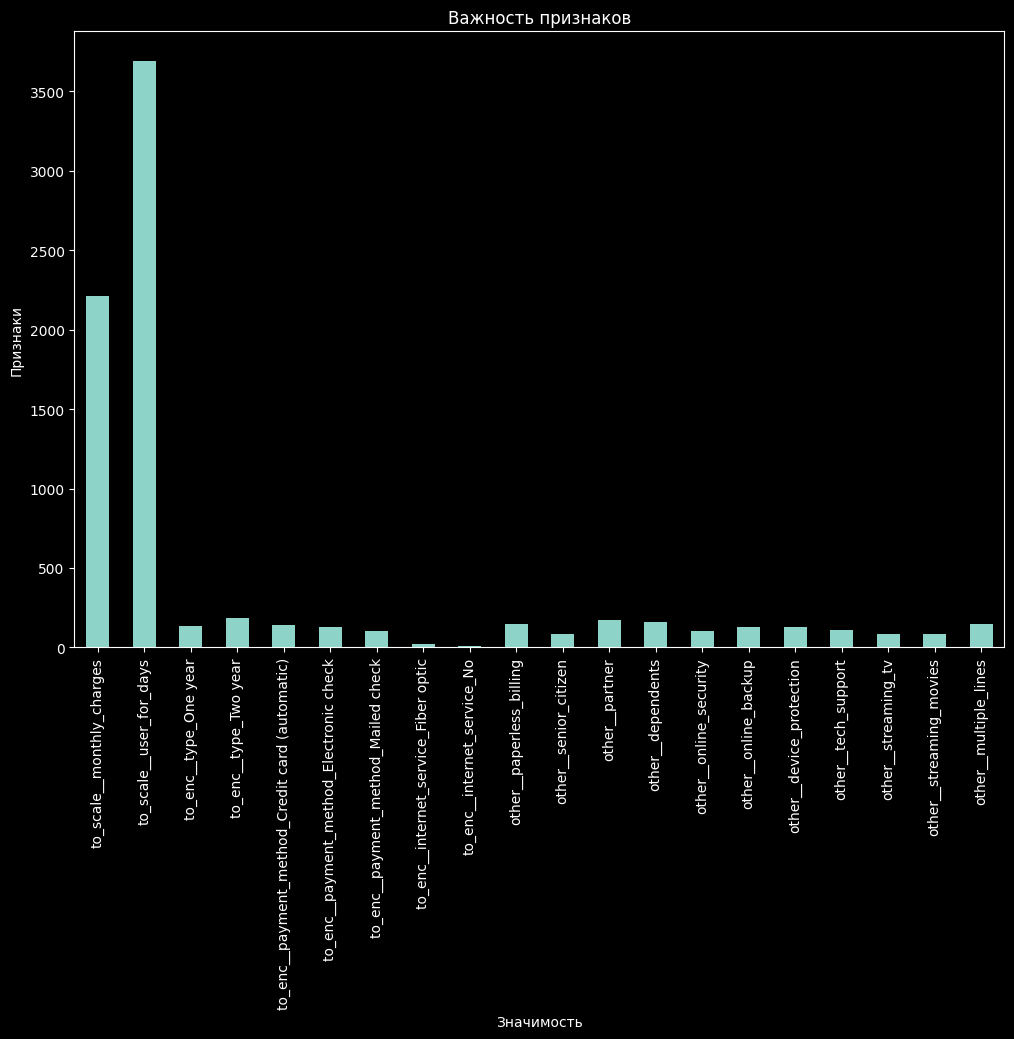

In [38]:
importances = pd.Series(test_pipe.steps[1][1].feature_importances_,
                         test_pipe.named_steps['preprocessor'].get_feature_names_out())

fig, ax = plt.subplots(figsize=(12,8))
importances.plot.bar(ax=ax)
plt.title('Важность признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.show()

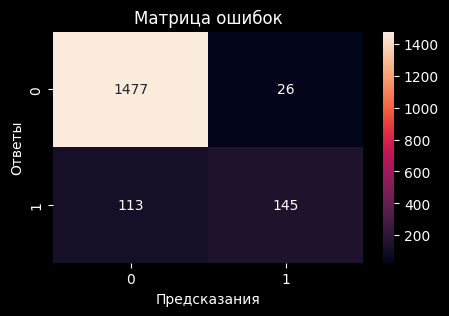

In [39]:
lgbm_cmxm = pd.DataFrame(confusion_matrix(y_test, predict))

plt.figure(figsize=(5,3))
plt.title('Матрица ошибок')
sns.heatmap(lgbm_cmxm, annot=True, fmt='d')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

### Проверим модель на адекватность

In [40]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
dummy_predict = dummy_clf.predict(X_test)
dummy_roc_auc = roc_auc_score(dummy_predict, y_test)
dummy_accuracy = accuracy_score(dummy_predict, y_test)

if test_roc_auc > dummy_roc_auc:
    print(f'ROC-AUC метрика нашей модели ({round(test_roc_auc, 4)}) '
    f'выше чем в модели случайного подбора параметров '
    f'({round(dummy_roc_auc, 4)}), наша модель адекватна')
else:
    print(f'F1 метрика нашей модели ({round(test_roc_auc, 4)}) '
    f'ниже чем чем в модели случайного подбора параметров '
    f'({round(dummy_roc_auc, 4)}), наша модель неадекватна')


if test_accuracy > dummy_accuracy:
    print(f'Accuracy метрика нашей модели ({round(test_accuracy, 4)}) '
    f'выше чем в модели случайного подбора параметров '
    f'({round(dummy_accuracy, 4)}), наша модель адекватна')
else:
    print(f'Accuracy метрика нашей модели ({round(test_accuracy, 4)}) '
    f'ниже чем чем в модели случайного подбора параметров '
    f'({round(dummy_accuracy, 4)}), наша модель неадекватна')

ROC-AUC метрика нашей модели (0.9163) выше чем в модели случайного подбора параметров (0.4917), наша модель адекватна
Accuracy метрика нашей модели (0.9211) выше чем в модели случайного подбора параметров (0.4855), наша модель адекватна


# Отчёт

Проделанная работа:

Ключевые шаги:
- анализ данных
- отбор признаков
- поиск параметров на кроссвалидации и выбор лучшей модели
- тестирование лучшей модели

По итогу работы найдена лучшая модель и параметры для неё, ей оказалась `LGBMClassifier`.

На тестовой выборке модель показала следующие метрики: 
- `ROC-AUC` = 0.924
- `Accuracy` = 0.932

Шаги более детально: 
- данные загружены и проанализированны
- данные объеденены в один общий датасет
- в датасете заполнены пропуски
- из признака `EndDate` выделен целевой признак (клиенты, которые ушли)
- рассчитан дополнительный признак, количество дней пользования (`user_for_days`) из признаков начала и окончания пользования (`BeginDate` и `EndDate`)
    - признаки начала и окончания пользования (`BeginDate` и `EndDate`) удалены за ненадобностью
- выдвинуты и проверены гипотезы в значимости категориальных признаков
    - по итогу проверки принято решение избавится от признака пола (`Gender`), так как гипотезу о том что этот признак не значим отвергнуть не удалось
- проанализирована мультиколлинеарность признаков
    - по итогу анализа принято решение избавится от признака общие затраты(`TotalCharges`), так как этот признак сильно коррелировал с остальными количественными признаками
- удален признак `customerID `, этот признак уникальный для каждой строки и не нужен длы обучения модели
- датасет разбит на тренировочную и тестовую выборки
- применяется `pipline` в котором производится: 
    - паралельная обработка:
        - кодирование категориальных признаков с помощью `OneHotEncoder`
        - стандартизация количественных признаков с помощью `StandartScaler`
    - обучение модели
- Для поиска лучшей модели и лучших параметров для неё, использовались `GridSearchCV` и `RandomizedSearchCV`
- Для оценки качества моделей использовались метрики `ROC-AUC` и `Accuracy`
- лучшая моддель искалась среди следующих кандидатов:
    - `LogisticRegression`
    - `RandomForestClassifier`
    - `LGBMClassifier`
- найдена лучшая модель и параметры для неё, ей оказалась `LGBMClassifier`
    - параметры, которые мы подобрали:
        - `num_leaves` = 37, 
        - `n_estimators` = 700, 
        - `max_depth` = 4, 
        - `learning_rate` = 0.08
- модель проверена на адеквстсность с помощью `DummyClassifier`

Все пункты [плана](#plan) были выполнены

Возникшие трудности:

- много повторяющихся, однотипных действий
    - решено написанием функций, для автоматизации этих действий
- возникла сложность в отрисовке кривой `ROC-AUC` на результатах кроссвалидации
    - вывел, хотя результат отличается от того что выдаёт `RandomizedSearchCV`, что смущает
